In [49]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from psm_utils import Peptidoform
from alphapept.fasta import cleave_sequence

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

from denovo_utils.parsers.io.fasta import FastaHandler
from denovo_utils.parsers.constants import EXTENSIONS
from denovo_utils.parsers import DenovoEngineConverter
from denovo_utils.analysis.metaproteomics import count_analysis
from denovo_utils.utils.pandas import get_decoy_status, get_species_specificity, count_species_peptides, get_psm_type

from Bio.SeqRecord import SeqRecord



In [ ]:
root_results = "/home/samva/Doctorate/data_directory/denovo_project/denovo_results"
engine = "sage"
filename = "S03"

root_results_filtered = os.path.join(root_results, "psmlists/df")

# FASTA experiments

The FASTA defines what you expect to see in a sample when doing a search. Therefore, the only thing you will identify, is what you expect to see in your sample, which you define with your FASTA database. However, in de novo sequencing, you are not dependent on this required database. So the idea is to enrich the database with what you find in a de novo search and to find species-specific peptide sequences.

To evaluate the efficacy of de novo sequencing to capture unexpected species in a sample, a FASTA-blinding study will be performed. In essence, the database search is performed a number of times but with different databases, e.g. removing all sequences from a given species. Afterwards, the identifications that are lost in this search (those from the species present in the sample whereof the sequences are removed from the database) are tried to be recaptured by appending the de novo identifications and performing the search again. As final evaluation, the overlap will be calculated between the identifications of that species from the blinded fasta search, the original search, and the de novo enriched search.


Of course, some identifications will differ by adding de novo sequences. These could indicate a better peptide sequence proposition from de novo engines, albeit without support (and thus confidence) from a database. To evaluate this tendency, the same scoring evaluation will be performed (as done in notebook 6) but with a more interpretable scoring function -> hyperscore + MS2Rescore -> Percolator

# 0. Parse a fasta file

## 0.1 Read fasta file

In [2]:
root_fasta = "/home/samva/Doctorate/data_directory/fasta"
pd.read_csv(os.path.join(root_fasta, "sdrf.tsv"))

,TAXONOMY,PROTEOME_ID,FILE,CONTENTS,DATE_DOWNLOAD
0,Homo sapiens (Human),UP000005640,uniprotkb_proteome_UP000005640_2024_07_31.fasta,sp;tr;isoforms;contaminant,31_07_2024
1,Homo sapiens (Human),UP000005640,uniprotkb_proteome_UP000005640_AND_revi_2024_0...,sp;isoforms;contaminant,31_07_2024
2,Homo sapiens (Human),UP000005640,UP000005640_9606.fasta,sp;contaminant,31_07_2024
3,Saccharomyces cerevisiae (strain ATCC 204508 /...,UP000002311,UP000002311.fasta,sp;contaminant,31_07_2024
4,Escherichia coli (strain K12),UP000000625,UP000000625.fasta,sp;contaminant,31_07_2024
5,Human;Yeast;E.coli,UP000000625;UP000002311;UP000005640,UP000005640_9606.fasta,sp;contaminant,31_07_2024
6,?,?,GUT_DB2MG.fasta,source:PXD023217,NaN
7,?,?,SIHUMI_DB1UNIPROT.fasta,source:PXD023217,NaN


In [3]:
fasta = FastaHandler()
fasta.read(
    os.path.join(
        root_fasta,
        "SIHUMI_DB1UNIPROT.fasta"
    )
)
fasta.dataframe["organism"] = fasta.dataframe["organism"].fillna("Contaminant")
fasta_organism_protein_dict = fasta.to_dict(key="organism", value="protein_id_full")

fasta.dataframe.head(2)

,name,protein_id,protein_id_full,protein_description,organism,gene_name,protein_existence,sequence_version,sequence
0,TrEMBL,B0MEB3,tr|B0MEB3|B0MEB3_9FIRM,Ribonuclease HII,Anaerostipes caccae DSM 14662,rnhB,3,1,"(M, R, E, E, S, Y, R, E, A, L, M, T, K, Q, E, ..."
1,TrEMBL,B0MBJ7,tr|B0MBJ7|B0MBJ7_9FIRM,Tagatose-6-phosphate kinase,Anaerostipes caccae DSM 14662,pfkB,3,1,"(M, I, T, T, V, T, L, N, A, S, I, D, K, A, Y, ..."


In [4]:
fasta.dataframe.organism.value_counts()

organism
Bacteroides thetaiotaomicron (strain ATCC 29148 / DSM 2079 / NCTC 10582 / E50 / VPI-5482)    4782
Blautia sp. YL58                                                                             4502
Escherichia coli (strain K12)                                                                4306
Clostridium butyricum E4 str. BoNT E BL5262                                                  4245
Anaerostipes caccae DSM 14662                                                                3743
Erysipelatoclostridium ramosum DSM 1402                                                      3166
Lactobacillus plantarum (strain ATCC BAA-793 / NCIMB 8826 / WCFS1)                           3088
Bifidobacterium longum (strain NCC 2705)                                                     1725
Contaminant                                                                                   116
Name: count, dtype: int64

## 0.2. Split up the fasta file by removing one species from it

In [5]:
fasta.dataframe.head(2)

,name,protein_id,protein_id_full,protein_description,organism,gene_name,protein_existence,sequence_version,sequence
0,TrEMBL,B0MEB3,tr|B0MEB3|B0MEB3_9FIRM,Ribonuclease HII,Anaerostipes caccae DSM 14662,rnhB,3,1,"(M, R, E, E, S, Y, R, E, A, L, M, T, K, Q, E, ..."
1,TrEMBL,B0MBJ7,tr|B0MBJ7|B0MBJ7_9FIRM,Tagatose-6-phosphate kinase,Anaerostipes caccae DSM 14662,pfkB,3,1,"(M, I, T, T, V, T, L, N, A, S, I, D, K, A, Y, ..."


In [6]:
from itertools import combinations

organisms = set(fasta.organisms)
organism_combinations = list(combinations(
    organisms,
    len(organisms)-1
))

# Store the combination of organisms in dict with key the deleted organism
organism_fasta_dict = {}
for organism_combination in organism_combinations:
    organism_combination_list = list(organism_combination)
    for organism in organisms:
        if organism not in organism_combination:
            organism_fasta_dict[organism.split()[0]] = organism_combination_list
            continue

for deleted_organism, organism_combination in organism_fasta_dict.items():
    boolean_filter = fasta.dataframe["organism"].isin(organism_combination)
    out_path = os.path.join(root_fasta, f"del_{deleted_organism}_SIHUMI_DB1UNIPROT.fasta")

    # Uncomment this to write files to the path
    # fasta.write(
    #     boolean_filter=boolean_filter,
    #     out_path=out_path
    # )

    print("Written fasta to {}.".format(out_path))

Written fasta to /home/samva/Doctorate/data_directory/fasta/del_Anaerostipes_SIHUMI_DB1UNIPROT.fasta.
Written fasta to /home/samva/Doctorate/data_directory/fasta/del_Erysipelatoclostridium_SIHUMI_DB1UNIPROT.fasta.
Written fasta to /home/samva/Doctorate/data_directory/fasta/del_Contaminant_SIHUMI_DB1UNIPROT.fasta.
Written fasta to /home/samva/Doctorate/data_directory/fasta/del_Bacteroides_SIHUMI_DB1UNIPROT.fasta.
Written fasta to /home/samva/Doctorate/data_directory/fasta/del_Clostridium_SIHUMI_DB1UNIPROT.fasta.
Written fasta to /home/samva/Doctorate/data_directory/fasta/del_Lactobacillus_SIHUMI_DB1UNIPROT.fasta.
Written fasta to /home/samva/Doctorate/data_directory/fasta/del_Escherichia_SIHUMI_DB1UNIPROT.fasta.
Written fasta to /home/samva/Doctorate/data_directory/fasta/del_Bifidobacterium_SIHUMI_DB1UNIPROT.fasta.
Written fasta to /home/samva/Doctorate/data_directory/fasta/del_Blautia_SIHUMI_DB1UNIPROT.fasta.


## 0.3 Additionally, create a fasta file by appending de novo sequences

This should be done on a file-by-file basis

For now, nothing is done regarding looking for redundancies. The sequences that are found are just appended to the end of the fasta as such. Also, they are appended as individual fasta entries.

In [6]:
filename="F01_Fraction1"
path_filtered_psms = os.path.join(
    root_results, "psmlists/df", filename+".csv"
)
filtered_psms_df = pd.read_csv(path_filtered_psms)

In [32]:
import pandas as pd
import json
from denovo_utils.parsers.io.fasta import FastaHandler

# ADD DENOVO SEQUENCES TO THE FASTA
path_denovo_file = "/home/samva/Doctorate/data_directory/denovo_project/denovo_results/psmlists/df/S11_Fraction1.csv"

path_fasta = '/home/samva/Doctorate/data_directory/fasta/del_Blautia_SIHUMI_DB1UNIPROT.fasta'
fasta_basename = os.path.basename(path_fasta).split(".")[0]
fasta_path = f'{fasta_basename}_denovo.fasta'

path_search_config = '/home/samva/Doctorate/DeNovo_Benchmark/configs/sage/denovo_fasta_ablation.json'
path_search_config_out = path_search_config.split('.')[0] + '_new.json'

denovo_engine = 'Casanovo4.2.0'


denovo_psms = pd.read_csv(path_denovo_file)
denovo_psms = denovo_psms[denovo_psms.source==denovo_engine]

fasta = FastaHandler()
fasta.read(path_fasta)
fasta.add_denovo_sequences(denovo_psms)
boolean_filter = [True]*len(fasta.dataframe)

# fasta.write(
#     boolean_filter=boolean_filter,
#     out_path=f'./{fasta_basename}_denovo.fasta'
# )
print(f'Written new fasta file: {fasta_basename}_denovo.fasta')


# Add new fasta to config file and dump it as a new json file.
with open(path_search_config, 'r') as f:
    json_file = json.load(f)
    json_file['database']['fasta'] = fasta_path

# with open(path_search_config_out, 'w') as f:
#     json.dump(json_file, f)
print(f'write fasta field in {path_search_config_out}.')

Written new fasta file: del_Blautia_SIHUMI_DB1UNIPROT_denovo.fasta
write fasta field in /home/samva/Doctorate/DeNovo_Benchmark/configs/sage/denovo_fasta_ablation_new.json.


In [47]:
fasta_check = FastaHandler()

fasta_check.read("/home/samva/Doctorate/data_directory/fasta/denovo/del_Anaerostipes_SIHUMI_DB1UNIPROT_denovo.fasta")
fasta_check.dataframe["organism"].value_counts()

Casanovo4.2.0                                                                                23605
Bacteroides thetaiotaomicron (strain ATCC 29148 / DSM 2079 / NCTC 10582 / E50 / VPI-5482)     4782
Blautia sp. YL58                                                                              4502
Escherichia coli (strain K12)                                                                 4306
Clostridium butyricum E4 str. BoNT E BL5262                                                   4245
Erysipelatoclostridium ramosum DSM 1402                                                       3166
Lactobacillus plantarum (strain ATCC BAA-793 / NCIMB 8826 / WCFS1)                            3088
Bifidobacterium longum (strain NCC 2705)                                                      1725
Contaminant                                                                                    116
Name: organism, dtype: int64

# 1. Check how many species-specific peptides were detected in S-samples with database searching

In [5]:
filename = "S07"

df_sage_filtered, count_table = count_analysis(
    path_file=os.path.join(
        root_results,
        engine,
        filename+EXTENSIONS[engine]
    ),
    psm_types=["target_accepted", "target_rejected"],
    fasta_dict=fasta_organism_protein_dict,
    plot=False
)

100%|██████████| 30548/30548 [00:00<00:00, 2672108.42it/s]


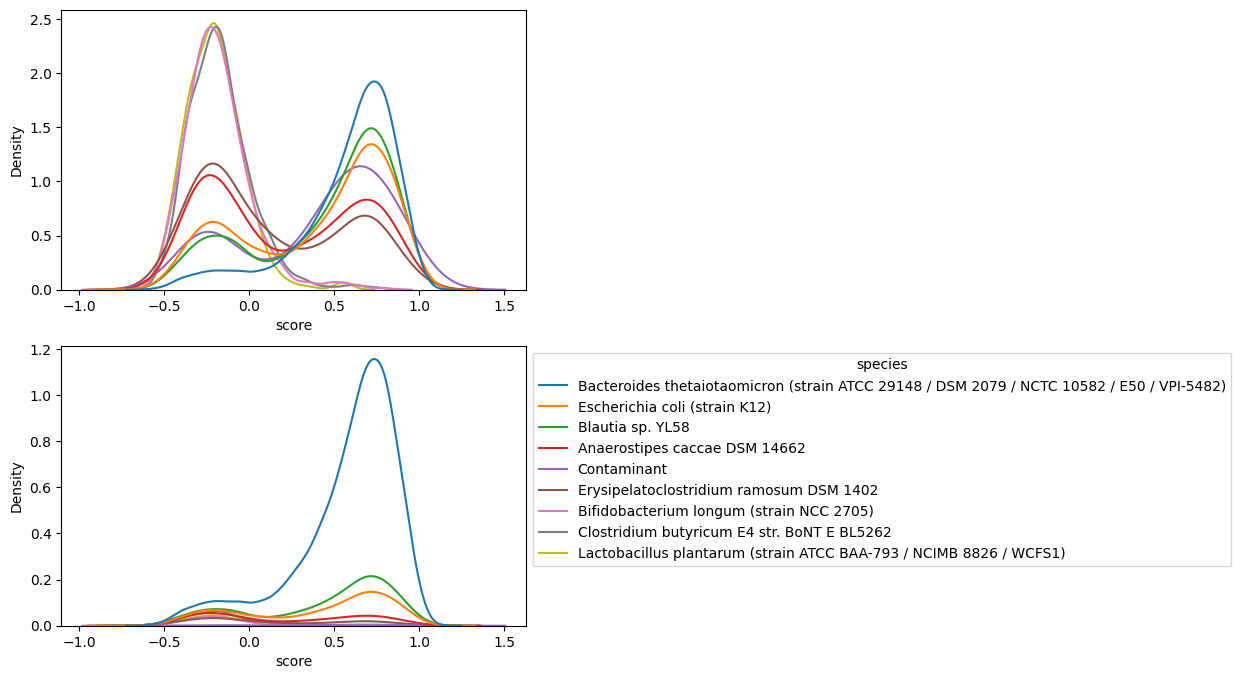

In [6]:
df_sage_unique_species = df_sage_filtered[df_sage_filtered["species_n"]==1].copy()
df_sage_unique_species["species"] = df_sage_unique_species["species"].apply(lambda x: x[0])

fig, ax = plt.subplots(2,1, figsize=(6,8))
sns_plot = sns.kdeplot(
    df_sage_unique_species,
    x="score",
    hue="species",
    common_norm=False,
    ax=ax[0],
    legend=False
)
sns_plot2 = sns.kdeplot(
    df_sage_unique_species,
    x="score",
    hue="species",
    common_norm=True,
    ax=ax[1]
)
sns.move_legend(sns_plot2, "upper left", bbox_to_anchor=(1, 1))

In [7]:
count_table

,species,count_specific,count_all
0,Bacteroides thetaiotaomicron (strain ATCC 2914...,17951,18133
1,Blautia sp. YL58,4304,4817
2,Escherichia coli (strain K12),3266,3391
3,Anaerostipes caccae DSM 14662,1557,2000
4,Erysipelatoclostridium ramosum DSM 1402,848,1013
5,Clostridium butyricum E4 str. BoNT E BL5262,776,997
6,Lactobacillus plantarum (strain ATCC BAA-793 /...,548,634
7,Bifidobacterium longum (strain NCC 2705),500,560
8,Contaminant,125,128


## Try for another S-file

100%|██████████| 115334/115334 [00:00<00:00, 2678014.67it/s]


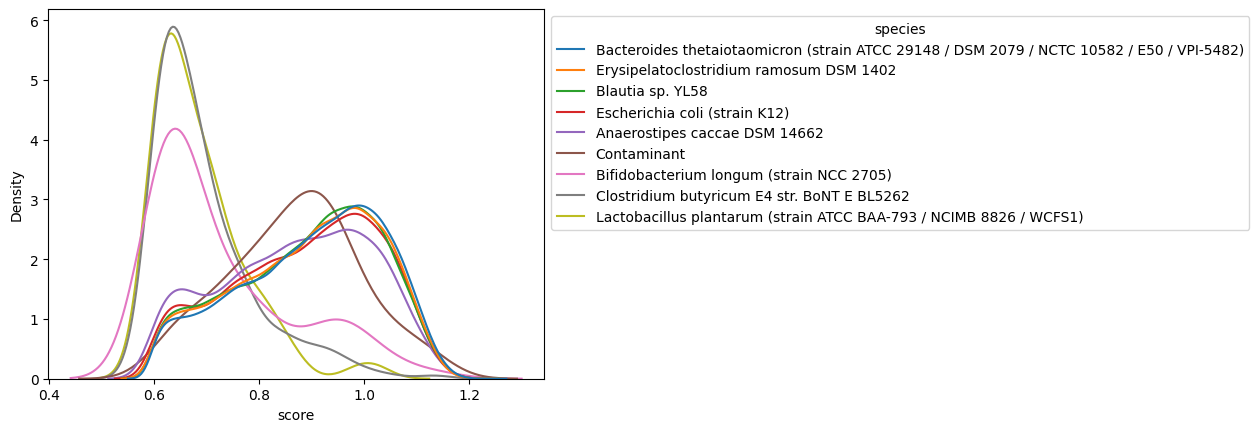

In [8]:
filename = "S05"

df_sage_filtered, count_table = count_analysis(
    path_file=os.path.join(
        root_results,
        engine,
        filename+EXTENSIONS[engine]
    ),
    psm_types=["target_accepted"],
    fasta_dict=fasta_organism_protein_dict,
    plot=True
)

In [9]:
count_table

,species,count_specific,count_all
0,Bacteroides thetaiotaomicron (strain ATCC 2914...,61438,62402
1,Blautia sp. YL58,20051,23233
2,Erysipelatoclostridium ramosum DSM 1402,18220,19725
3,Escherichia coli (strain K12),7519,8108
4,Anaerostipes caccae DSM 14662,3398,5826
5,Clostridium butyricum E4 str. BoNT E BL5262,243,1399
6,Contaminant,137,141
7,Bifidobacterium longum (strain NCC 2705),123,442
8,Lactobacillus plantarum (strain ATCC BAA-793 /...,120,554


Metaproteomics rabbit hole:

Are the species-specific peptides that were found here, which follow a distinct distribution and have only a very limited of supporting peptides, actually very similar to what are supposed to be 'entrapment' sequences which actually follow the decoy distribution better?

Instead of only looking at the accepted PSMs, look at all of the target PSM's without filtering. If they indeed follow the decoy distribution, this could support the hypothesis

In [10]:
df_sage_filtered, count_table = count_analysis(
    path_file=os.path.join(
        root_results,
        engine,
        filename+EXTENSIONS[engine]
    ),
    psm_types=["target_accepted", "target_rejected"],
    fasta_dict=fasta_organism_protein_dict,
    plot=False
)

100%|██████████| 156093/156093 [00:00<00:00, 2345692.33it/s]


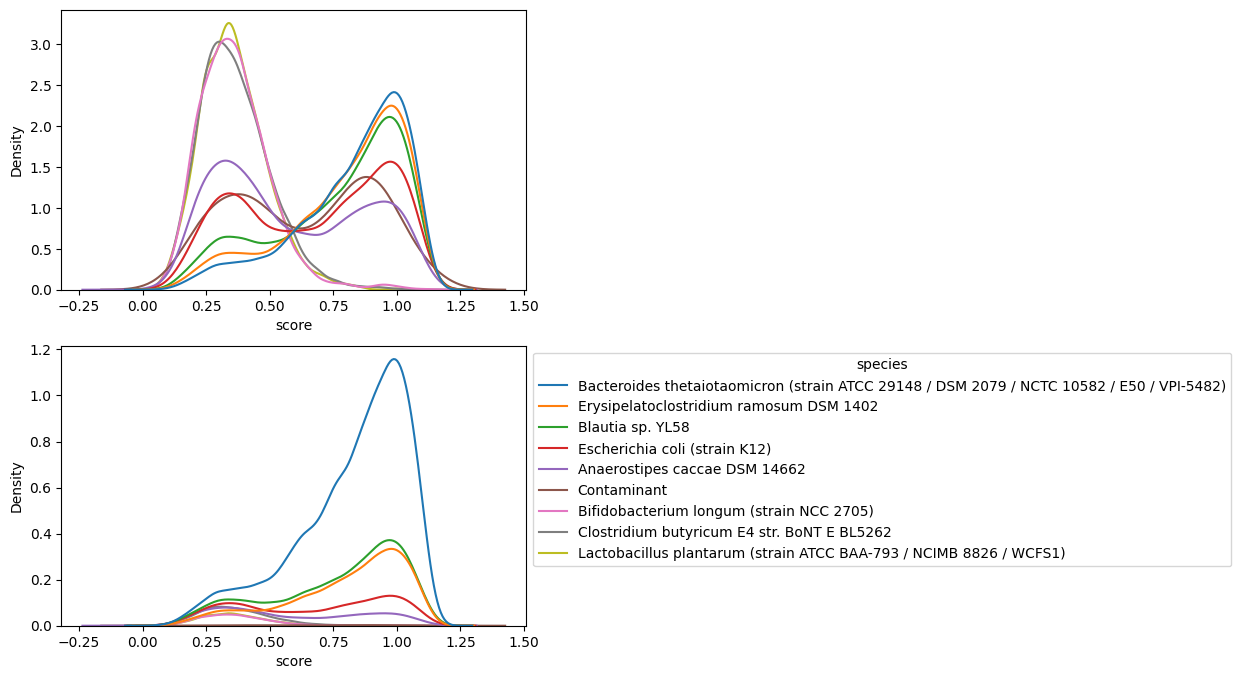

In [11]:
df_sage_unique_species = df_sage_filtered[df_sage_filtered["species_n"]==1].copy()
df_sage_unique_species["species"] = df_sage_unique_species["species"].apply(lambda x: x[0])

fig, ax = plt.subplots(2,1, figsize=(6,8))
sns_plot = sns.kdeplot(
    df_sage_unique_species,
    x="score",
    hue="species",
    common_norm=False,
    ax=ax[0],
    legend=False
)
sns_plot2 = sns.kdeplot(
    df_sage_unique_species,
    x="score",
    hue="species",
    common_norm=True,
    ax=ax[1]
)
sns.move_legend(sns_plot2, "upper left", bbox_to_anchor=(1, 1))

In [12]:
count_table

,species,count_specific,count_all
0,Bacteroides thetaiotaomicron (strain ATCC 2914...,72746,73810
1,Blautia sp. YL58,26697,30268
2,Erysipelatoclostridium ramosum DSM 1402,22506,24195
3,Escherichia coli (strain K12),12621,13309
4,Anaerostipes caccae DSM 14662,7590,10365
5,Clostridium butyricum E4 str. BoNT E BL5262,4139,5447
6,Lactobacillus plantarum (strain ATCC BAA-793 /...,2507,3002
7,Bifidobacterium longum (strain NCC 2705),2403,2758
8,Contaminant,256,262


The following species are probably not in the sample:
- Bifidobacterium longum
- Clostridium butyricum
- Lactobacillus plantarum

Don't know about, maybe just present at lower abundance:
- Anaerostipes caccae
- Eschericihia coli

These follow a similar distribution as the contaminants, which are probably in the sample!

In short, there seem to be 3 distributions

If we follow this train of thought, these species could in fact function as negative controls for the de novo pipeline when performing the fasta-blinding experiment.

Potential artefact however is that there are much less sequences of these species in the fasta file. I should actually count the number of unique peptides that can be found for these species.

# 2. Build the de novo fasta blinding pipeline

Strategy:

1. Take the search results including all species as ground-truth.
2. Perform an ablation experiment by doing a search, excluding species x from the fasta file.
3. Perform a third search by including the de novo predictions from the de novo search engines to the fasta.
4. Perform a fourth search where only de novo predictions + contaminants are added (this will be done automatically when treating Contaminant as species).
5. Analyse the difference between search 1. and search 3. in terms of species coverage, where coverage means the peptide-PSM pairs matching to the given species.

### 2.0 Load the data

In [13]:
filename="S07"

sources = ["Casanovo4.2.0", "sage"]

path_filtered_psms = os.path.join(
    root_results, "psmlists/df", filename+".csv"
)

# Load the PSM table
df = pd.read_csv(path_filtered_psms)
df["protein_list"] = df["protein_list"].fillna("None")
df["protein_list"] = df["protein_list"].apply(eval)
df["protein_list"] = df["protein_list"].apply(lambda x: None if x == "None" else x)
df["is_decoy"] = df.apply(get_decoy_status, axis=1)
df = df[df["source"].isin(sources)]
df_dn = df[df["source"]==sources[0]]
df_db = df[df["source"]==sources[1]]

# Load the FASTA file
fasta = FastaHandler()
fasta.read("/home/samva/Doctorate/data_directory/fasta/SIHUMI_DB1UNIPROT.fasta")
fasta.dataframe["organism"] = fasta.dataframe["organism"].fillna("Contaminant")
df_fasta = fasta.dataframe

# Create FASTA entry dictionaries
fasta_org_protid = fasta.to_dict(key="organism", value="protein_id_full")
fasta_org_seq = fasta.to_dict(key="organism", value="sequence")
fasta_org_seq = {
    k: [str(x).replace("I", "L") for x in v] for k, v in fasta_org_seq.items()
}

In [14]:
df_db_confident = df_db[df_db["psm_type"]=="target_accepted"]
df_db_confident["species"] = df_db["protein_list"].progress_apply(lambda x: get_species_specificity(protein_list=x, fasta_dict=fasta_org_protid))
df_db_confident["species_n"] = df_db_confident["species"].apply(len)
df_db_confident["sequence"] = 

100%|██████████| 36926/36926 [00:04<00:00, 8418.57it/s]


In [94]:
df_db_confident

,peptidoform,spectrum_id,run,collection,spectrum,is_decoy,score,qvalue,pep,precursor_mz,...,metadata,rescoring_features,spectralis_score,psm_type,peptide,gmm_cluster,correct_prediction,species,species_n,sequence
105796,IQNSGDYFSGITDEELLSR,controllerType=0 controllerNumber=1 scan=35850,S07,NaN,NaN,False,1.222346,0.000182,NaN,1073.013575,...,{},"{'expmass': 2144.0115, 'calcmass': 2143.007, '...",-0.025445,target_accepted,LQNSGDYFSGLTDEELLSR,1,True,[Bacteroides thetaiotaomicron (strain ATCC 291...,1,IQNSGDYFSGITDEELLSR
105797,C[UNIMOD:4]LIIGSGPAGYTAAIYAGR,controllerType=0 controllerNumber=1 scan=34773,S07,NaN,NaN,False,1.219388,0.000182,NaN,955.995075,...,{},"{'expmass': 1909.9745, 'calcmass': 1909.9722, ...",-0.459725,target_accepted,C[UNIMOD:4]LLLGSGPAGYTAALYAGR,1,True,[Bacteroides thetaiotaomicron (strain ATCC 291...,1,CLIIGSGPAGYTAAIYAGR
105798,LQSTC[UNIMOD:4]QGILMAELPTER,controllerType=0 controllerNumber=1 scan=32551,S07,NaN,NaN,False,1.210560,0.000182,NaN,973.990175,...,{},"{'expmass': 1945.9647, 'calcmass': 1945.9602, ...",-0.189845,target_accepted,LQSTC[UNIMOD:4]QGLLMAELPTER,1,True,[Bacteroides thetaiotaomicron (strain ATCC 291...,1,LQSTCQGILMAELPTER
105799,MYEFADRLINLALPR,controllerType=0 controllerNumber=1 scan=40240,S07,NaN,NaN,False,1.202430,0.000182,NaN,607.995492,...,{},"{'expmass': 1820.963, 'calcmass': 1820.9608, '...",-0.488078,target_accepted,MYEFADRLLNLALPR,1,True,"[Blautia sp. YL58, Anaerostipes caccae DSM 14662]",2,MYEFADRLINLALPR
105800,VLPQDQASNGGQNDGSSSAR,controllerType=0 controllerNumber=1 scan=9609,S07,NaN,NaN,False,1.201236,0.000182,NaN,994.458425,...,{},"{'expmass': 1986.9012, 'calcmass': 1986.899, '...",-0.736623,target_accepted,VLPQDQASNGGQNDGSSSAR,1,True,[Bacteroides thetaiotaomicron (strain ATCC 291...,1,VLPQDQASNGGQNDGSSSAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129479,MIPC[UNIMOD:4]SVYLEGEYGESDIC[UNIMOD:4]IGVPVILGK,controllerType=0 controllerNumber=1 scan=41875,S07,NaN,NaN,False,0.224386,0.009885,NaN,1000.155358,...,{},"{'expmass': 2997.4426, 'calcmass': 2997.4536, ...",-1.514563,target_accepted,MLPC[UNIMOD:4]SVYLEGEYGESDLC[UNIMOD:4]LGVPVLLGK,1,True,[Bacteroides thetaiotaomicron (strain ATCC 291...,1,MIPCSVYLEGEYGESDICIGVPVILGK
129480,GLIVDLR,controllerType=0 controllerNumber=1 scan=23308,S07,NaN,NaN,False,0.224366,0.009885,NaN,393.248060,...,{},"{'expmass': 784.48047, 'calcmass': 784.4806, '...",-1.376654,target_accepted,GLLVDLR,1,True,[Clostridium butyricum E4 str. BoNT E BL5262],1,GLIVDLR
129481,LMDDTLPLSIGGGIGQSR,controllerType=0 controllerNumber=1 scan=36125,S07,NaN,NaN,False,0.224104,0.009885,NaN,915.456725,...,{},"{'expmass': 1828.8978, 'calcmass': 1828.9353, ...",-1.680505,target_accepted,LMDDTLPLSLGGGLGQSR,1,True,[Bacteroides thetaiotaomicron (strain ATCC 291...,1,LMDDTLPLSIGGGIGQSR
129482,WVFEK,controllerType=0 controllerNumber=1 scan=20415,S07,NaN,NaN,False,0.224080,0.009885,NaN,354.690200,...,{},"{'expmass': 707.36475, 'calcmass': 707.36426, ...",-0.442206,target_accepted,WVFEK,1,True,[Bacteroides thetaiotaomicron (strain ATCC 291...,1,WVFEK


In [15]:
species_list = list(fasta_org_protid.keys())+["Contaminant"]

### 2.1 Get species coverage in percentage

In [16]:
def sequence_in_species(sequence_observed: str, species_sequences: dict):
    species_list = []
    for species, sequences in species_sequences.items():
        for sequence in sequences:
            if sequence_observed in sequence:
                species_list.append(species)
                break
    return species_list

df_dn["sequence"] = df_dn["peptidoform"].apply(lambda x: Peptidoform(x).sequence.replace("I", "L"))
df_dn["species"] = df_dn["sequence"].progress_apply(
    lambda x: sequence_in_species(sequence_observed=x, species_sequences=fasta_org_seq)
)
df_dn["species_n"] = df_dn["species"].apply(len)

100%|██████████| 21349/21349 [01:34<00:00, 224.97it/s]


In [17]:
species_count_db_specific = count_species_peptides(
    df=df_db_confident,
    species_list=species_list,
    specific=True
)
species_count_db_unspecific = count_species_peptides(
    df=df_db_confident,
    species_list=species_list,
    specific=False
)
species_count_db = species_count_db_specific.merge(species_count_db_unspecific)


species_count_dn_specific = count_species_peptides(
    df=df_dn,
    species_list=species_list,
    specific=True
)
species_count_dn_unspecific = count_species_peptides(
    df=df_dn,
    species_list=species_list,
    specific=False
)
species_count_dn = species_count_dn_specific.merge(species_count_dn_unspecific)


count_table = species_count_db.merge(species_count_dn, on="species", suffixes=["_db", "_dn"])

count_table["proportion_specific_db"] = count_table["count_specific_db"].apply(lambda x: x/count_table["count_specific_db"].sum())
count_table["proportion_specific_dn"] = count_table["count_specific_dn"].apply(lambda x: x/count_table["count_specific_dn"].sum())

count_table["proportion_all_db"] = count_table["count_all_db"].apply(lambda x: x/count_table["count_all_db"].sum())
count_table["proportion_all_dn"] = count_table["count_all_dn"].apply(lambda x: x/count_table["count_all_dn"].sum())

org_n_sequences = {
    k: sum(
        [
            len(cleave_sequence(
                i,
                n_missed_cleavages=2,
                pep_length_min=5,
                pep_length_max=50
            )) for i in v
        ]
    ) for k, v in fasta_org_seq.items()
}
count_table["n_theoretical"] = count_table["species"].apply(lambda x: org_n_sequences[x])

count_table["normalized_n"] = count_table.apply(lambda x: x["count_all_db"]/x["n_theoretical"], axis=1)

100%|██████████| 21349/21349 [00:00<00:00, 2755629.98it/s]


<Axes: ylabel='species'>

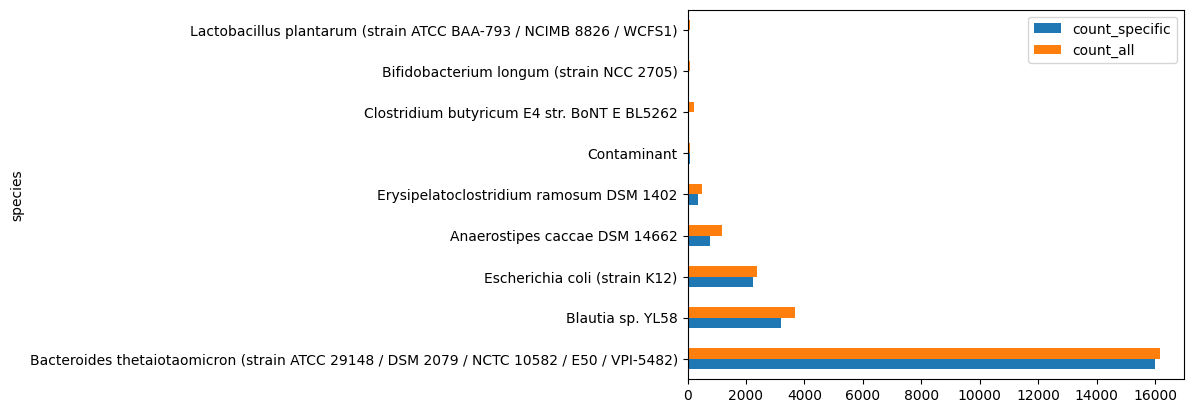

In [18]:
species_count_db.sort_values("count_specific", ascending=False).set_index("species").plot(kind="barh")

In [19]:
count_table

,species,count_specific_db,count_all_db,count_specific_dn,count_all_dn,proportion_specific_db,proportion_specific_dn,proportion_all_db,proportion_all_dn,n_theoretical,normalized_n
0,Bacteroides thetaiotaomicron (strain ATCC 2914...,15999,16166,10512,11044,0.703933,0.714470,0.664174,0.624731,480598,0.033637
1,Blautia sp. YL58,3213,3676,2047,2674,0.141367,0.139129,0.151027,0.151261,370581,0.009920
2,Escherichia coli (strain K12),2254,2361,1438,1756,0.099173,0.097737,0.097001,0.099333,301483,0.007831
3,Anaerostipes caccae DSM 14662,765,1169,423,944,0.033659,0.028750,0.048028,0.053400,300662,0.003888
4,Erysipelatoclostridium ramosum DSM 1402,342,490,209,484,0.015048,0.014205,0.020131,0.027379,241107,0.002032
5,Contaminant,90,92,68,75,0.003960,0.004622,0.003780,0.004243,9469,0.009716
6,Clostridium butyricum E4 str. BoNT E BL5262,33,229,7,371,0.001452,0.000476,0.009408,0.020987,368062,0.000622
7,Bifidobacterium longum (strain NCC 2705),23,75,7,135,0.001012,0.000476,0.003081,0.007637,137234,0.000547
8,Lactobacillus plantarum (strain ATCC BAA-793 /...,9,82,2,195,0.000396,0.000136,0.003369,0.011031,194140,0.000422


<Axes: ylabel='species'>

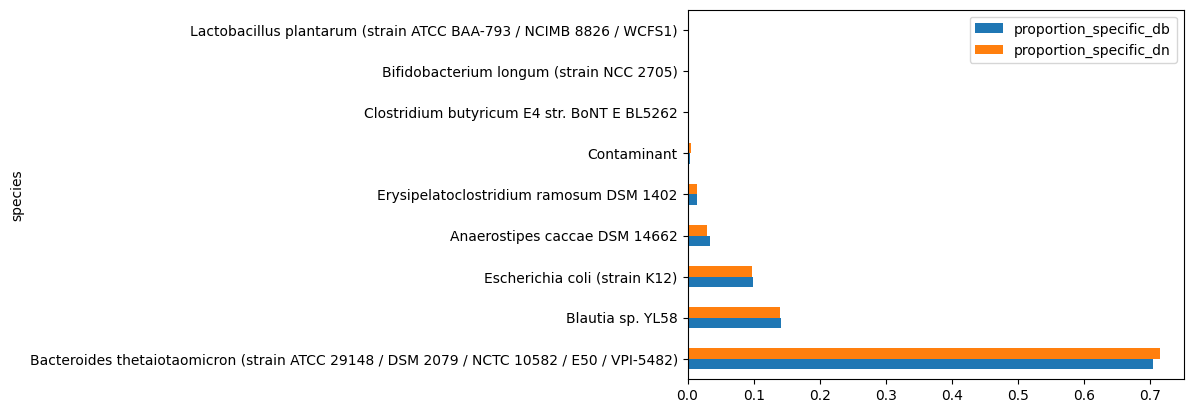

In [25]:
count_table[["species", "proportion_specific_db", "proportion_specific_dn"]].set_index("species").plot(kind="barh")

<Axes: ylabel='species'>

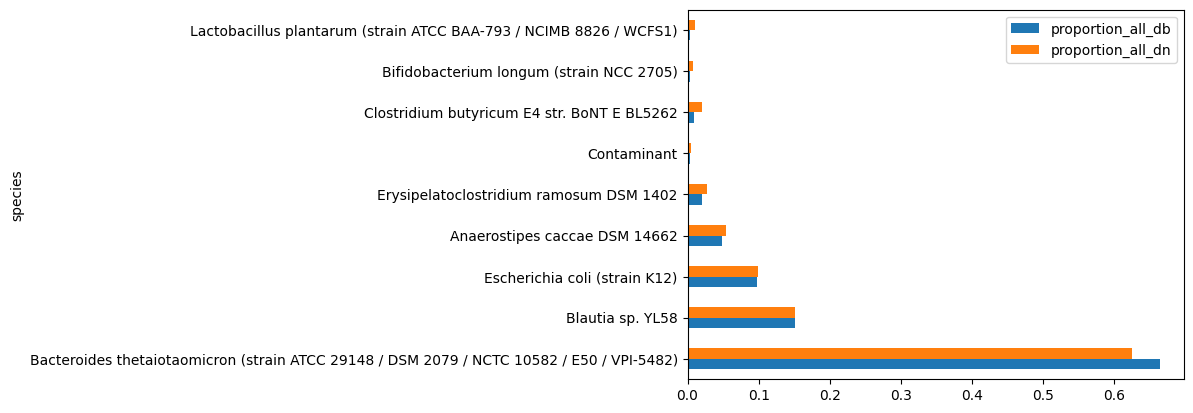

In [26]:
count_table[["species", "proportion_all_db", "proportion_all_dn"]].set_index("species").plot(kind="barh")

In [20]:
count_table.apply(lambda x: x["count_specific_db"]/x["count_all_db"], axis=1)

0    0.989670
1    0.874048
2    0.954680
3    0.654405
4    0.697959
5    0.978261
6    0.144105
7    0.306667
8    0.109756
dtype: float64

In [109]:
parser = DenovoEngineConverter.select("sage")

df_sage_blautia_denovo = parser.parse(
    "/home/samva/Doctorate/data_directory/denovo_project/search_results/del_Blautia_SIHUMI_DB1UNIPROT_denovo/identification/S07.sage.tsv",
    mgf_path=""
).to_dataframe()
df_sage_blautia = parser.parse(
    "/home/samva/Doctorate/data_directory/denovo_project/search_results/del_Blautia_SIHUMI_DB1UNIPROT/identification/S07.sage.tsv",
    mgf_path=""
).to_dataframe()

df_sage_lacto_denovo = parser.parse(
    "/home/samva/Doctorate/data_directory/denovo_project/search_results/del_Lactobacillus_SIHUMI_DB1UNIPROT_denovo/identification/S07.sage.tsv",
    mgf_path=""
).to_dataframe()
df_sage_lacto = parser.parse(
    "/home/samva/Doctorate/data_directory/denovo_project/search_results/del_Lactobacillus_SIHUMI_DB1UNIPROT/identification/S07.sage.tsv",
    mgf_path=""
).to_dataframe()

In [110]:
df_sage_blautia_denovo["psm_type"] = df_sage_blautia_denovo.apply(get_psm_type, axis=1)
df_sage_blautia["psm_type"] = df_sage_blautia.apply(get_psm_type, axis=1)
df_sage_lacto_denovo["psm_type"] = df_sage_lacto_denovo.apply(get_psm_type, axis=1)
df_sage_lacto["psm_type"] = df_sage_lacto.apply(get_psm_type, axis=1)

df_sage_blautia_denovo = df_sage_blautia_denovo[df_sage_blautia_denovo["psm_type"]=="target_accepted"]
df_sage_blautia = df_sage_blautia[df_sage_blautia["psm_type"]=="target_accepted"]
df_sage_lacto_denovo = df_sage_lacto_denovo[df_sage_lacto_denovo["psm_type"]=="target_accepted"]
df_sage_lacto = df_sage_lacto[df_sage_lacto["psm_type"]=="target_accepted"]

df_sage_blautia_denovo["sequence"] = df_sage_blautia_denovo["peptidoform"].apply(lambda x: x.sequence.replace("I", "L"))
df_sage_blautia["sequence"] = df_sage_blautia["peptidoform"].apply(lambda x: x.sequence.replace("I", "L"))
df_sage_lacto_denovo["sequence"] = df_sage_lacto_denovo["peptidoform"].apply(lambda x: x.sequence.replace("I", "L"))
df_sage_lacto["sequence"] = df_sage_lacto["peptidoform"].apply(lambda x: x.sequence.replace("I", "L"))

df_db_confident["sequence"] = df_db_confident["peptidoform"].apply(lambda x: Peptidoform(x).sequence.replace("I", "L"))

In [111]:
set_sage_blautia_denovo = set([(x["sequence"], x["spectrum_id"]) for x in df_sage_blautia_denovo[["sequence", "spectrum_id"]].to_dict("records")])
set_sage_blautia = set([(x["sequence"], x["spectrum_id"]) for x in df_sage_blautia[["sequence", "spectrum_id"]].to_dict("records")])
set_sage_lacto_denovo = set([(x["sequence"], x["spectrum_id"]) for x in df_sage_lacto_denovo[["sequence", "spectrum_id"]].to_dict("records")])
set_sage_lacto = set([(x["sequence"], x["spectrum_id"]) for x in df_sage_lacto[["sequence", "spectrum_id"]].to_dict("records")])

set_sage_original = set([(x["sequence"], x["spectrum_id"]) for x in df_db_confident[["sequence", "spectrum_id"]].to_dict("records")])

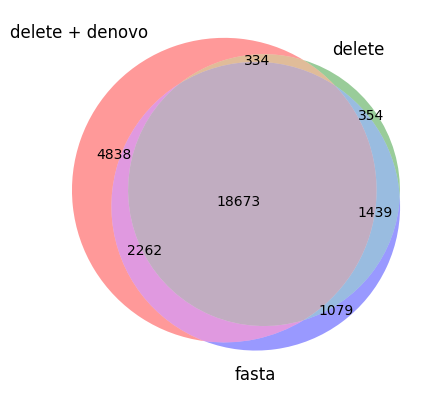

In [112]:
from matplotlib_venn import venn3

venn3(
    subsets= (set_sage_blautia_denovo, set_sage_blautia, set_sage_original),
    set_labels=("delete + denovo", "delete", "fasta")
)

In [114]:
def sequence_in_species(sequence_observed: str, species_sequences: dict):
    species_list = []
    for species, sequences in species_sequences.items():
        for sequence in sequences:
            if sequence_observed in sequence:
                species_list.append(species)
                break
    return species_list

df_sage_blautia_denovo["species"] = df_sage_blautia_denovo["sequence"].progress_apply(
    lambda x: sequence_in_species(sequence_observed=x, species_sequences=fasta_org_seq)
)
df_sage_blautia_denovo["species_n"] = df_sage_blautia_denovo["species"].apply(len)

species_count_db_specific_bd = count_species_peptides(
    df=df_sage_blautia_denovo,
    species_list=species_list,
    specific=True
)
species_count_db_unspecific_bd = count_species_peptides(
    df=df_sage_blautia_denovo,
    species_list=species_list,
    specific=False
)
species_count_db_bd = species_count_db_specific_bd.merge(species_count_db_unspecific_bd)


count_table_bd = species_count_db_bd

count_table_bd["proportion_specific"] = count_table_bd["count_specific"].apply(lambda x: x/count_table_bd["count_specific"].sum())
count_table_bd["proportion_all"] = count_table_bd["count_all"].apply(lambda x: x/count_table_bd["count_all"].sum())

org_n_sequences = {
    k: sum(
        [
            len(cleave_sequence(
                i,
                n_missed_cleavages=2,
                pep_length_min=5,
                pep_length_max=50
            )) for i in v
        ]
    ) for k, v in fasta_org_seq.items()
}
count_table_bd["n_theoretical"] = count_table_bd["species"].apply(lambda x: org_n_sequences[x])

count_table_bd["normalized_n"] = count_table_bd.apply(lambda x: x["count_all"]/x["n_theoretical"], axis=1)

100%|██████████| 26107/26107 [00:00<00:00, 3128144.39it/s]


In [116]:
count_table.sort_values("species")

,species,count_specific_db,count_all_db,count_specific_dn,count_all_dn,proportion_specific_db,proportion_specific_dn,proportion_all_db,proportion_all_dn,n_theoretical,normalized_n
3,Anaerostipes caccae DSM 14662,765,1169,423,944,0.033659,0.028750,0.048028,0.053400,300662,0.003888
0,Bacteroides thetaiotaomicron (strain ATCC 2914...,15999,16166,10512,11044,0.703933,0.714470,0.664174,0.624731,480598,0.033637
7,Bifidobacterium longum (strain NCC 2705),23,75,7,135,0.001012,0.000476,0.003081,0.007637,137234,0.000547
1,Blautia sp. YL58,3213,3676,2047,2674,0.141367,0.139129,0.151027,0.151261,370581,0.009920
6,Clostridium butyricum E4 str. BoNT E BL5262,33,229,7,371,0.001452,0.000476,0.009408,0.020987,368062,0.000622
5,Contaminant,90,92,68,75,0.003960,0.004622,0.003780,0.004243,9469,0.009716
4,Erysipelatoclostridium ramosum DSM 1402,342,490,209,484,0.015048,0.014205,0.020131,0.027379,241107,0.002032
2,Escherichia coli (strain K12),2254,2361,1438,1756,0.099173,0.097737,0.097001,0.099333,301483,0.007831
8,Lactobacillus plantarum (strain ATCC BAA-793 /...,9,82,2,195,0.000396,0.000136,0.003369,0.011031,194140,0.000422


In [115]:
count_table_bd.sort_values("species")

,species,count_specific,count_all,proportion_specific,proportion_all,n_theoretical,normalized_n
3,Anaerostipes caccae DSM 14662,727,1313,0.034593,0.054871,300662,0.004367
0,Bacteroides thetaiotaomicron (strain ATCC 2914...,15239,15690,0.725114,0.655690,480598,0.032647
6,Bifidobacterium longum (strain NCC 2705),38,145,0.001808,0.006060,137234,0.001057
1,Blautia sp. YL58,2276,2959,0.108298,0.123657,370581,0.007985
7,Clostridium butyricum E4 str. BoNT E BL5262,38,410,0.001808,0.017134,368062,0.001114
5,Contaminant,89,93,0.004235,0.003886,9469,0.009822
4,Erysipelatoclostridium ramosum DSM 1402,363,629,0.017273,0.026286,241107,0.002609
2,Escherichia coli (strain K12),2225,2494,0.105872,0.104225,301483,0.008272
8,Lactobacillus plantarum (strain ATCC BAA-793 /...,21,196,0.000999,0.008191,194140,0.001010


In [122]:
count_table_merged = count_table.merge(count_table_bd[["species", "proportion_specific"]])

<Axes: ylabel='species'>

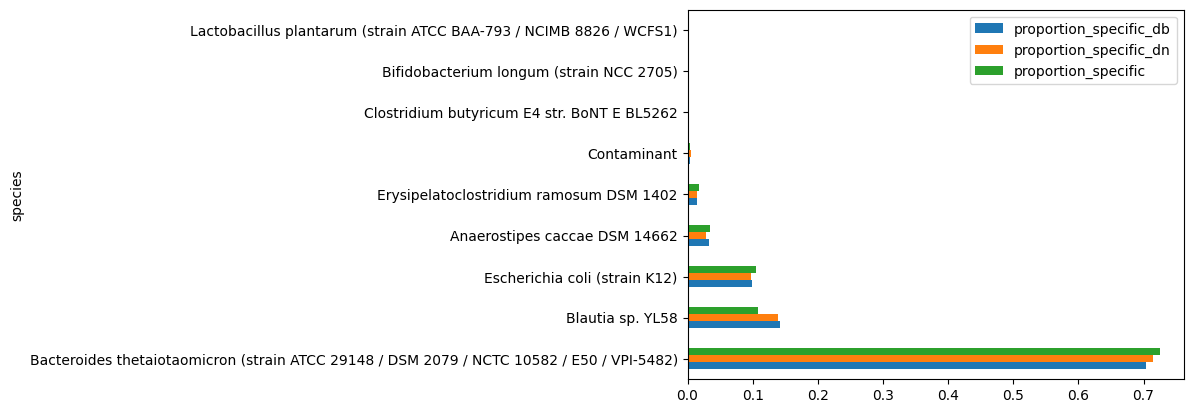

In [123]:
count_table_merged[["species", "proportion_specific_db", "proportion_specific_dn", "proportion_specific"]].set_index("species").plot(kind="barh")

In [117]:
def get_source(protein_list):
    sources = {"denovo": False,
               "fasta": False}

    for protein in protein_list:
        if protein.startswith("dn|"):
            sources["denovo"]=True
        else:
            sources["fasta"]=True
    
    if sum(sources.values())==2:
        return "shared"
    elif sources["denovo"]:
        return "denovo"
    return "fasta"

df_sage_blautia_denovo["source"] = df_sage_blautia_denovo["protein_list"].apply(get_source)

In [118]:
df_sage_blautia_denovo["source"].value_counts()

source
denovo    10902
fasta      9053
shared     6152
Name: count, dtype: int64

<Axes: xlabel='score', ylabel='Density'>

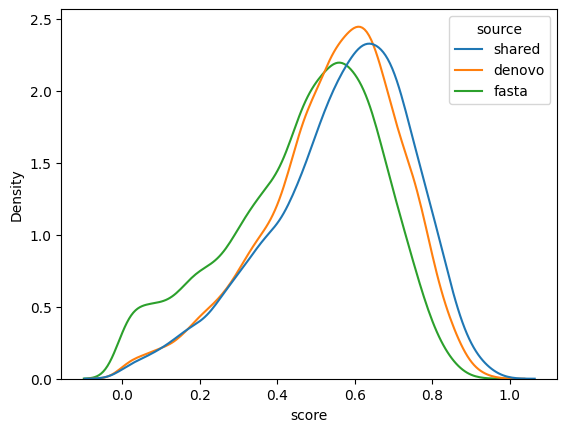

In [67]:
sns.kdeplot(
    df_sage_blautia_denovo,
    x="score",
    hue="source",
    common_norm=False
)

In [113]:
from sklearn.preprocessing import normalize

In [21]:
conf_table = (count_table.apply(lambda x: x["count_specific_db"]/x["count_all_db"], axis=1) * count_table["normalized_n"]).reset_index().set_index("index")
conf_table["species"] = count_table["species"]
conf_table = conf_table.set_index("species")

In [22]:
conf_table

,0
species,
Bacteroides thetaiotaomicron (strain ATCC 29148 / DSM 2079 / NCTC 10582 / E50 / VPI-5482),0.033290
Blautia sp. YL58,0.008670
Escherichia coli (strain K12),0.007476
Anaerostipes caccae DSM 14662,0.002544
Erysipelatoclostridium ramosum DSM 1402,0.001418
Contaminant,0.009505
Clostridium butyricum E4 str. BoNT E BL5262,0.000090
Bifidobacterium longum (strain NCC 2705),0.000168
Lactobacillus plantarum (strain ATCC BAA-793 / NCIMB 8826 / WCFS1),0.000046


<Axes: xlabel='0', ylabel='species'>

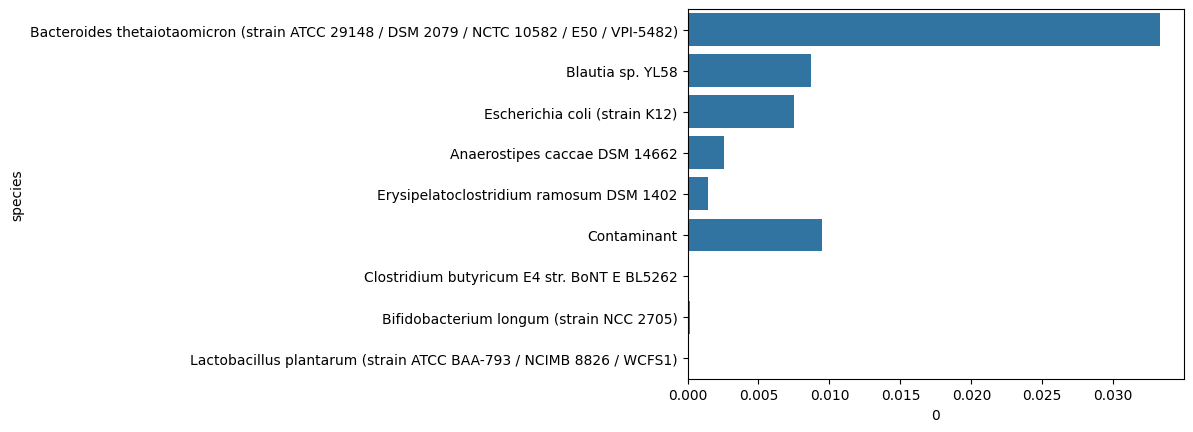

In [23]:
sns.barplot(
    conf_table.reset_index(),
    x=0,
    y="species"
)

Should I add a species I know is not in there? Should I look at the decoys? How can I set a threshold when a species is detected or not?

What if I use the sample of Bart, where I know the quantities and add an entrapment?! This way I can set a threshold, at which the species will not be in the sample!

De novo is in this way agnostic to the concept of fasta databases. I don't really know how many of the sequences in the fasta should be 'detected' in order to say the species is identified. I guess I can also include PSM confidence levels to the calculation. Maybe PepGM can provide some hints?

### 2.2 Is the proportion of de novo sequences I find constant with what is identified in a database search?

For database searching

In [ ]:
df_sage_filtered, count_table = count_analysis(
    path_file=os.path.join(
        root_results,
        engine,
        filename+EXTENSIONS[engine]
    ),
    psm_types=["target_accepted", "target_rejected"],
    fasta_dict=fasta_organism_protein_dict,
    plot=False
)

df_sage_unique_species = df_sage_filtered[df_sage_filtered["species_n"]==1].copy()
df_sage_unique_species["species"] = df_sage_unique_species["species"].apply(lambda x: x[0])

fig, ax = plt.subplots(2,1, figsize=(6,8))
sns_plot = sns.kdeplot(
    df_sage_unique_species,
    x="score",
    hue="species",
    common_norm=False,
    ax=ax[0],
    legend=False
)
sns_plot2 = sns.kdeplot(
    df_sage_unique_species,
    x="score",
    hue="species",
    common_norm=True,
    ax=ax[1]
)
sns.move_legend(sns_plot2, "upper left", bbox_to_anchor=(1, 1))

---

In [91]:
df_dn_species_sp = df_dn[df_dn["species_n"]==1].copy()
df_dn_species_sp["species"] = df_dn_species_sp["species"].apply(lambda x: x[0])

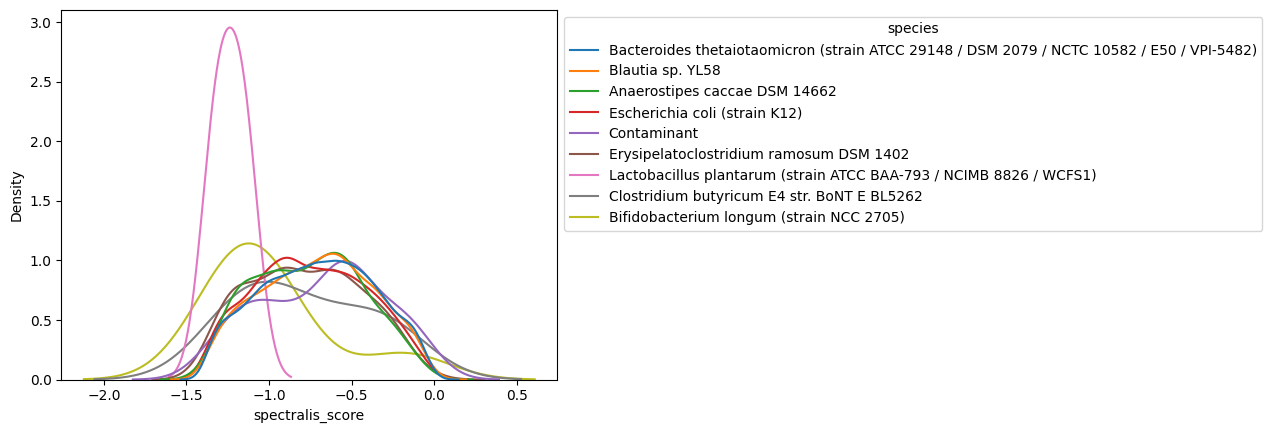

In [93]:
sns_plot = sns.kdeplot(
    df_dn_species_sp,
    x="spectralis_score",
    hue="species",
    common_norm=False
)
sns.move_legend(sns_plot, "upper left", bbox_to_anchor=(1, 1))

In [84]:
count_table.apply(lambda x: x["count_specific_db"]/x["n_theoretical_sequences"], axis=1).

0    0.033290
1    0.008670
2    0.007476
3    0.002544
4    0.001418
5    0.009505
6    0.000090
7    0.000168
8    0.000046
dtype: float64